In [1]:
# math 
import numpy as np
from scipy.linalg import norm

# random
from numpy.random import rand, randn
np.random.seed(6)

# plotting
import matplotlib.pyplot as plt

# robust regression 
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [2]:
def generate_data(n, w):
    X = randn(n,len(w))
    y = X@w
    return X, y

def generate_noisy_data(n, w):
    X = randn(n,len(w))
    y = X@w + .1*randn(n)
    return X, y

# OLS is invariant

In [3]:
d = 10
n = 20
w = randn(d)
X, y = generate_data(n, w);

In [4]:
LinearRegression?

In [5]:
lin = LinearRegression().fit(X,y)
yhat = lin.predict(X)
yhat

array([-0.71420156, -1.63516395, -3.8608605 , -0.57894597,  6.59638624,
       -4.79152845, -0.5736281 ,  5.18756905, -7.26414655,  5.32047682,
        3.56641161, -0.245102  ,  1.61110249,  2.61211864, -3.38682977,
        1.19532532,  4.86224655,  6.26788358,  4.48640507, -3.14514452])

In [6]:
yscale = 5*y
Xscale = 3*X
lin = LinearRegression().fit(Xscale,yscale)
yhatscale = lin.predict(Xscale)
yhatscale

array([ -3.57100781,  -8.17581975, -19.30430252,  -2.89472986,
        32.98193119, -23.95764226,  -2.8681405 ,  25.93784523,
       -36.32073277,  26.6023841 ,  17.83205803,  -1.22551002,
         8.05551247,  13.06059321, -16.93414883,   5.9766266 ,
        24.31123275,  31.33941792,  22.43202537, -15.72572261])

In [7]:
# predictions match up to scaling
norm(yhat - yhatscale/5)

2.4221204859038887e-14

# ridge regression is not scaling invariant

In [8]:
Ridge?

In [9]:
alpha = .1 # regularization parameter

lin = Ridge(alpha=alpha).fit(X,y)
yhat = lin.predict(X)
yhat

array([-0.73252921, -1.61138302, -3.871725  , -0.59222297,  6.55771702,
       -4.72195274, -0.56508244,  5.18633252, -7.21591302,  5.28679447,
        3.54741707, -0.21884335,  1.60849856,  2.58391179, -3.40339278,
        1.19486892,  4.83695027,  6.26115137,  4.48779252, -3.108016  ])

In [10]:
yscale = 5*y
Xscale = 3*X
lin = Ridge(alpha=alpha).fit(Xscale,yscale)
yhatscale = lin.predict(Xscale)
yhatscale

array([ -3.58216226,  -8.16285939, -19.31217038,  -2.90274427,
        32.95995686, -23.91745638,  -2.8628421 ,  25.93815093,
       -36.29302326,  26.58314257,  17.82078142,  -1.20993494,
         8.0550225 ,  13.04380232, -16.94425996,   5.97684365,
        24.29672683,  31.33609432,  22.43311342, -15.70431196])

In [11]:
# predictions do not match up to scaling
norm(yhat - yhatscale/5)

0.10923658080907492

In [12]:
# standardize

lin = Ridge(alpha=alpha, normalize=True).fit(X,y)
yhat = lin.predict(X)
yhat

yscale = 5*y
Xscale = 3*X
lin = Ridge(alpha=alpha, normalize=True).fit(Xscale,yscale)
yhatscale = lin.predict(Xscale)
yhatscale

# predictions match up to scaling
norm(yhat - yhatscale/5)

7.1041804156888074e-15

# let's compare different kinds of regularized regression

In [13]:
# generate data

d = 30
w_randn = randn(d)
w_sparse = w_randn*(abs(w_randn) > 1)
w_pos = w_randn*(w_randn > 0)

In [14]:
w_pos

array([-0.        ,  0.35483766,  0.2628088 , -0.        , -0.        ,
       -0.        , -0.        ,  1.13694227,  1.18705819,  1.69089583,
        0.49028137, -0.        , -0.        , -0.        , -0.        ,
        1.37681404, -0.        , -0.        ,  0.52907247,  0.73336413,
        0.96671585, -0.        , -0.        , -0.        ,  0.74307591,
        0.19329784, -0.        ,  1.89687218, -0.        , -0.        ])

In [15]:
w_sparse

array([-0.        ,  0.        ,  0.        , -0.        , -1.37105209,
       -1.06862477, -0.        ,  1.13694227,  1.18705819,  1.69089583,
        0.        , -1.44553018, -0.        , -1.15404442, -0.        ,
        1.37681404, -0.        , -0.        ,  0.        ,  0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        ,  1.89687218, -0.        , -0.        ])

In [16]:
# find best model for each type of data
w = w_randn

alpha_ridge=.1
alpha_lasso=.1

X,y = generate_data(30, w)
w_ridge = Ridge(alpha = alpha_ridge).fit(X,y).coef_
w_lasso = Lasso(alpha = alpha_lasso).fit(X,y).coef_
w_nonneg = LinearRegression(positive=True).fit(X,y).coef_

(array([3., 1., 2., 2., 4., 0., 1., 1., 3., 0., 2., 3., 0., 2., 0., 0., 2.,
        1., 1., 2.]),
 array([-1.37606868, -1.23186246, -1.08765624, -0.94345001, -0.79924379,
        -0.65503756, -0.51083134, -0.36662512, -0.22241889, -0.07821267,
         0.06599355,  0.21019978,  0.354406  ,  0.49861223,  0.64281845,
         0.78702467,  0.9312309 ,  1.07543712,  1.21964334,  1.36384957,
         1.50805579]),
 <BarContainer object of 20 artists>)

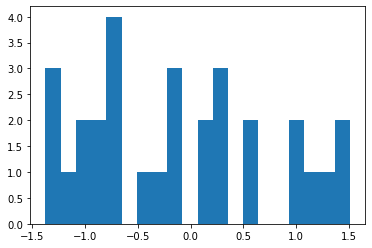

In [17]:
plt.hist(w_ridge, label="ridge coefficients", bins=20)

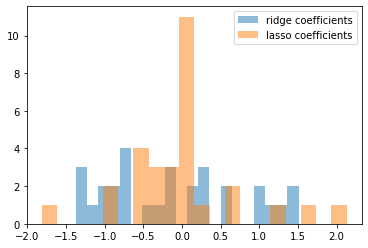

In [18]:
plt.hist(w_ridge, label="ridge coefficients", bins=20, alpha=.5)
plt.hist(w_lasso, label="lasso coefficients", bins=20, alpha=.5)
plt.legend()

Which coefficients are more sparse? (More 0 coefficients)
* A) ridge
* B) lasso

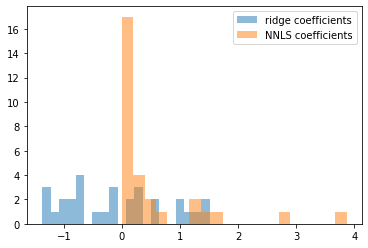

In [19]:
plt.hist(w_ridge, label="ridge coefficients", bins=20, alpha=.5)
plt.hist(w_nonneg, label="NNLS coefficients", bins=20, alpha=.5)
plt.legend()

Which coefficients are more sparse? (More 0 coefficients)
* A) ridge
* B) nonnegative least squares

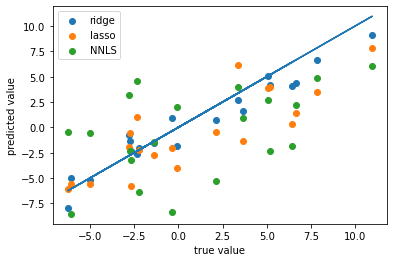

In [20]:
# which fits data best?
Xtest,ytest = generate_data(20,w_randn) # also try w_sparse and w_nonneg

yhat_ridge = Ridge(alpha = alpha_ridge).fit(X,y).predict(Xtest)
yhat_lasso = Lasso(alpha = alpha_lasso).fit(X,y).predict(Xtest)
yhat_nonneg = LinearRegression(positive=True).fit(X,y).predict(Xtest)

plt.plot(ytest,ytest)
plt.scatter(ytest, yhat_ridge, label="ridge")
plt.scatter(ytest, yhat_lasso, label="lasso")
plt.scatter(ytest, yhat_nonneg, label="NNLS")
plt.xlabel("true value")
plt.ylabel("predicted value")
plt.legend()

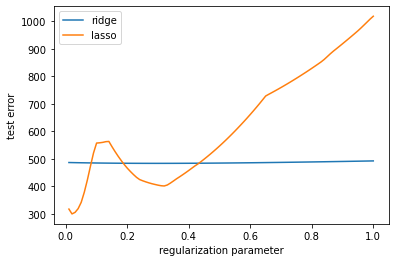

In [24]:
# cross validate over regularization parameter alpha
np.random.seed(6)

w = randn(40)
X,y = generate_noisy_data(30, w)
Xtest,ytest = generate_noisy_data(30, w)

ridge_error = []
lasso_error = []
alphas = np.linspace(.01,1,100)
for alpha in alphas:
    yhat_ridge = Ridge(alpha = alpha).fit(X,y).predict(Xtest)
    ridge_error.append(sum((ytest - yhat_ridge)**2))
    yhat_lasso = Lasso(alpha = alpha).fit(X,y).predict(Xtest)
    lasso_error.append(sum((ytest - yhat_lasso)**2))
plt.plot(alphas, ridge_error, label="ridge")
plt.plot(alphas, lasso_error, label="lasso")
plt.ylabel("test error")
plt.xlabel("regularization parameter")
plt.legend()

In [ ]:
ridge_error